In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import os

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bevan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bevan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bevan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)


In [5]:
df = pd.read_csv(r'dataset\clean_resume_data.csv')
# Ensure Feature column is string and drop NaNs
df = df.dropna(subset=['Feature'])
df['Feature'] = df['Feature'].astype(str)
df['cleaned_resume'] = df['Feature'].apply(preprocess_text)



In [6]:

# Encode target labels
label_encoder = LabelEncoder()
df['Category_encoded'] = label_encoder.fit_transform(df['Category'])
y = to_categorical(df['Category_encoded'])


In [7]:
# Tokenization and Padding
MAX_NUM_WORDS = 20000
MAX_SEQUENCE_LENGTH = 300
EMBEDDING_DIM = 100


In [8]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(df['cleaned_resume'])
sequences = tokenizer.texts_to_sequences(df['cleaned_resume'])
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [10]:
# Load GloVe embeddings
import os

def load_glove_embeddings(glove_path='glove.6B.100d.txt'):
    embeddings_index = {}
    with open(glove_path, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index


    # Prepare embedding matrix
def create_embedding_matrix(word_index, embeddings_index, max_num_words, embedding_dim):
    embedding_matrix = np.zeros((max_num_words, embedding_dim))
    for word, i in word_index.items():
        if i < max_num_words:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix


path_of_file = 'C:/Users/bevan/OneDrive/Desktop/fyp_project/Resume_catalyst/glove.6B/glove.6B.100d.txt'

# Use GloVe embeddings
if not os.path.exists(path_of_file):
    print("Please download GloVe embeddings from: https://nlp.stanford.edu/data/glove.6B.zip")
    raise SystemExit

embeddings_index = load_glove_embeddings(path_of_file)
embedding_matrix = create_embedding_matrix(tokenizer.word_index, embeddings_index, MAX_NUM_WORDS, EMBEDDING_DIM)


# Check GloVe coverage
num_known_words = sum(1 for word in tokenizer.word_index if word in embeddings_index)
print(f"Known words in GloVe: {num_known_words} / {len(tokenizer.word_index)}")




Known words in GloVe: 26325 / 34213


In [11]:
# Build enhanced RNN model
def create_model():
    model = Sequential()
    model.add(Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=True))
    model.add(SpatialDropout1D(0.3))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_model()


c:\Users\bevan\.conda\envs\Resume\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [12]:

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Class weights to handle imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(df['Category_encoded']), y=df['Category_encoded'])
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}


In [13]:

# Train model
# history = model.fit(
#     X_train, y_train,
#     validation_split=0.1,
#     epochs=30,
#     batch_size=32,
#     callbacks=[early_stopping],
#     class_weight=class_weights_dict
# )



history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=30,
    batch_size=32,
    class_weight=class_weights_dict
)

Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 29s 434ms/step - accuracy: 0.0568 - loss: 3.2013 - val_accuracy: 0.0452 - val_loss: 3.1678
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 397ms/step - accuracy: 0.0761 - loss: 3.1289 - val_accuracy: 0.0955 - val_loss: 3.0649
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 402ms/step - accuracy: 0.1143 - loss: 3.0006 - val_accuracy: 0.1457 - val_loss: 2.8721
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 424ms/step - accuracy: 0.1516 - loss: 2.9099 - val_accuracy: 0.2261 - val_loss: 2.6855
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 429ms/step - accuracy: 0.1938 - loss: 2.7610 - val_accuracy: 0.2864 - val_loss: 2.5440
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 441ms/step - accuracy: 0.2281 - loss: 2.5677 - val_accuracy: 0.2412 - val_loss: 2.4862
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 443ms/step - accuracy: 0.2327 - loss: 2.4777 - val_accuracy: 0.2764 - val_loss: 2.4714
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 446ms/step - accuracy: 0.3185 - loss: 2.3796 - val_accu

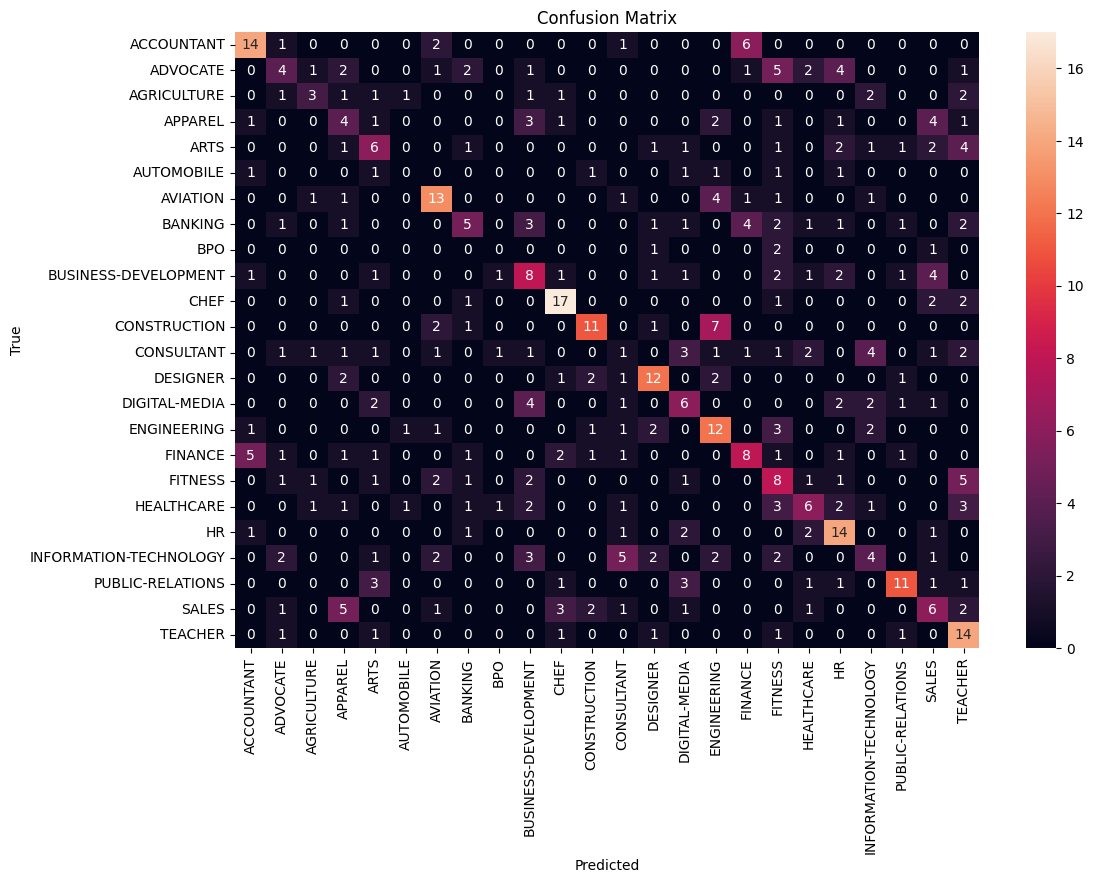

In [15]:
# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_, output_dict=True)

# Example: Get overall average scores
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

print("precision",precision)
print("Recall:",recall)
print("F1 Score:",f1_score)

precision 0.9383478920862616
Recall: 0.8062575452716298
F1 Score: 0.8648110202130583


In [ ]:
from sklearn.metrics import accuracy_score

# Assuming you've already predicted
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print("Accuracy:",accuracy)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step
Accuracy: 0.8762575452716298


In [ ]:
import pickle

with open('rf_classifier_categorization.pkl', 'wb') as file:
    pickle.dump(model, file)